# RNN Tutorial

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): 
    return glob.glob(path)

print(findFiles('./data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}  # 记录每个语言下的名字列表
all_categories = []  # 记录所有的语言

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

['./data/names\\Arabic.txt', './data/names\\Chinese.txt', './data/names\\Czech.txt', './data/names\\Dutch.txt', './data/names\\English.txt', './data/names\\French.txt', './data/names\\German.txt', './data/names\\Greek.txt', './data/names\\Irish.txt', './data/names\\Italian.txt', './data/names\\Japanese.txt', './data/names\\Korean.txt', './data/names\\Polish.txt', './data/names\\Portuguese.txt', './data/names\\Russian.txt', './data/names\\Scottish.txt', './data/names\\Spanish.txt', './data/names\\Vietnamese.txt']
57
Slusarski
18


Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)  # n_letters长的向量
    tensor[0][letterToIndex(letter)] = 1  # 对应位置为1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)  # batch_size=1
    for li, letter in enumerate(line):  # line_length 即句子长度
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating the Network
Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very “pure” way, as regular feed-forward layers.

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

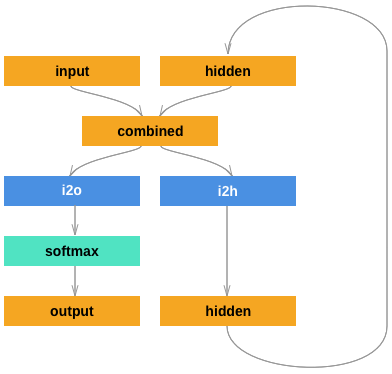

In [16]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.isLSTM = False

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # input_size + hidden_size -> hidden_size
        self.i2o = nn.Linear(input_size + hidden_size, output_size)  # input_size + hidden_size -> output_size
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)  # 连接input和hidden
        hidden = self.i2h(combined)  # hidden就在一直更新
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [17]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.isLSTM = True

        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size, hidden_size)  # pytorch封装好了
        self.out = nn.Linear(hidden_size, output_size)  # 由hidden_size -> output_size
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, h, c):
#         combined = torch.cat((input, hidden), 1)
        out, (h, c) = self.rnn(input, (h, c))
        output = self.out(out)
        output = self.softmax(output)
        return output, h, c

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)
print(lstm)

LSTM(
  (rnn): LSTM(57, 128)
  (out): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=-1)
)


To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [18]:
input = letterToTensor('A')
print(input.size())
hidden = torch.zeros(1, n_hidden)

h = rnn.initHidden()
output , next_h= rnn(input, h)
print(output.shape)
print(next_h.shape)

torch.Size([1, 57])
torch.Size([1, 18])
torch.Size([1, 128])


For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [19]:
input = lineToTensor('Albert')  # (6, 1, 57)
print(input.size())
hidden = torch.zeros(1, n_hidden)

h = rnn.initHidden()
output, h = rnn(input[0], h)
print(torch.exp(output))

torch.Size([6, 1, 57])
tensor([[0.0555, 0.0557, 0.0609, 0.0553, 0.0530, 0.0547, 0.0568, 0.0547, 0.0502,
         0.0599, 0.0591, 0.0522, 0.0559, 0.0545, 0.0554, 0.0544, 0.0556, 0.0561]],
       grad_fn=<ExpBackward0>)


In [20]:
input = lineToTensor('Albert')  # (6, 1, 57)
print(input.size())
hidden = torch.zeros(1, n_hidden)

h, c = lstm.initHidden()
output, h, c = lstm(input, h, c)
print(torch.exp(output))

torch.Size([6, 1, 57])
tensor([[[0.0574, 0.0555, 0.0531, 0.0528, 0.0595, 0.0596, 0.0584, 0.0526,
          0.0591, 0.0521, 0.0541, 0.0550, 0.0544, 0.0540, 0.0543, 0.0544,
          0.0581, 0.0555]],

        [[0.0579, 0.0551, 0.0520, 0.0530, 0.0591, 0.0590, 0.0582, 0.0518,
          0.0590, 0.0516, 0.0545, 0.0558, 0.0533, 0.0539, 0.0547, 0.0558,
          0.0593, 0.0562]],

        [[0.0577, 0.0561, 0.0518, 0.0535, 0.0597, 0.0586, 0.0575, 0.0522,
          0.0590, 0.0512, 0.0546, 0.0562, 0.0531, 0.0540, 0.0542, 0.0560,
          0.0590, 0.0556]],

        [[0.0573, 0.0563, 0.0521, 0.0534, 0.0602, 0.0593, 0.0572, 0.0524,
          0.0587, 0.0510, 0.0544, 0.0566, 0.0534, 0.0541, 0.0545, 0.0559,
          0.0586, 0.0546]],

        [[0.0572, 0.0557, 0.0516, 0.0533, 0.0610, 0.0580, 0.0572, 0.0526,
          0.0580, 0.0509, 0.0535, 0.0566, 0.0537, 0.0546, 0.0545, 0.0574,
          0.0588, 0.0555]],

        [[0.0578, 0.0546, 0.0511, 0.0538, 0.0608, 0.0580, 0.0569, 0.0524,
          0.0577, 

As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

### Preparing for Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [21]:
def categoryFromOutput(output):
    # top_n: 概率最大的值， top_i: 概率最大的值的索引
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 5)


We will also want a quick way to get a training example (a name and its language):

In [22]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)  # 随机选择一个语言
    line = randomChoice(category_lines[category])  # 随机选择一个名字
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)  # 转换为tensor 一维
    line_tensor = lineToTensor(line)  # 转换为tensor
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Salib
category = Irish / line = Fearghal
category = Dutch / line = Cann
category = Chinese / line = Nao
category = French / line = Perrot
category = Japanese / line = Oyama
category = Arabic / line = Totah
category = Irish / line = Daly
category = French / line = Cornett
category = Korean / line = Chin


### Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [23]:
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [28]:
learning_rate = 0.1 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor, net):
    if net.isLSTM == True:
        h0, c0 = net.initHidden()
    else:
        h0 = net.initHidden()

    net.zero_grad()

    if net.isLSTM == True:
        # 直接输入整个句子就可以，pytorch会自动处理
        output, h, c = net(line_tensor, h0, c0)
    else:
        # 一次输入一个字符
        for i in range(line_tensor.size()[0]):
            output, h0 = net(line_tensor[i], h0)

    if net.isLSTM == True:
        loss = criterion(output[-1], category_tensor)  # 取最后一个输出
    else:
        loss = criterion(output, category_tensor)
    loss.backward()  # 计算梯度

    # Add parameters' gradients to their values, multiplied by learning rate
    # 没有使用optimizer，手动更新参数
    for p in net.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [10]:
import time
import math

# 迭代和打印的设置
n_iters = 300000
print_every = 5000
plot_every = 1000

# 用于计算时间
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_and_print(net):
    # Keep track of losses & accuracies for plotting
    current_loss = 0
    current_accuracy = 0
    all_losses = []
    all_accuracy = []
    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(category_tensor, line_tensor, net)
        
        current_loss += loss
        if net.isLSTM == True:
            guess, guess_i = categoryFromOutput(output[-1])
        else:
            guess, guess_i = categoryFromOutput(output)
        if guess == category:
            current_accuracy += 1

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_accuracy.append(current_accuracy / plot_every)
            current_loss = 0
            current_accuracy = 0
    return all_losses, all_accuracy

In [ ]:
loss_rnn, accucay_rnn = train_and_print(rnn)

In [29]:
loss_lstm, accucay_lstm = train_and_print(lstm)

5000 1% (0m 11s) 2.7675 Chastain / Scottish ✗ (French)
10000 3% (0m 23s) 2.6911 Silva / Czech ✗ (Portuguese)
15000 5% (0m 36s) 1.2218 Koury / Arabic ✓
20000 6% (0m 47s) 2.4472 Augustin / Russian ✗ (French)
25000 8% (0m 58s) 0.5726 Hoang / Vietnamese ✓
30000 10% (1m 9s) 0.0392 Lubutov / Russian ✓
35000 11% (1m 20s) 1.6954 Wizner / German ✗ (Czech)
40000 13% (1m 32s) 0.3738 Malecha / Czech ✓
45000 15% (1m 43s) 3.7772 Petersen / Dutch ✗ (Czech)
50000 16% (1m 55s) 1.1058 Pachr / Czech ✓
55000 18% (2m 6s) 0.0055 Ikina / Japanese ✓
60000 20% (2m 17s) 0.0174 Cham / Arabic ✓
65000 21% (2m 29s) 0.6909 Zimmerman / German ✓
70000 23% (2m 40s) 0.0376 Ueshima / Japanese ✓
75000 25% (2m 51s) 3.3030 Ventura / Spanish ✗ (Italian)
80000 26% (3m 3s) 0.0020 Nghiem / Vietnamese ✓
85000 28% (3m 14s) 0.1075 Araullo / Portuguese ✓
90000 30% (3m 26s) 0.0001 Quraishi / Arabic ✓
95000 31% (3m 37s) 0.0382 Min / Chinese ✓
100000 33% (3m 49s) 0.0007 Yamamoto / Japanese ✓
105000 35% (4m 0s) 0.0077 Iwahara / Japanes

### Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_lines(losses, accuracy):
    plt.figure(figsize=(10,3))

    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title("loss")

    plt.subplot(1, 2, 2)
    plt.plot(accuracy)
    plt.title("accuracy")

In [ ]:
plot_lines(loss_rnn, accucay_rnn)

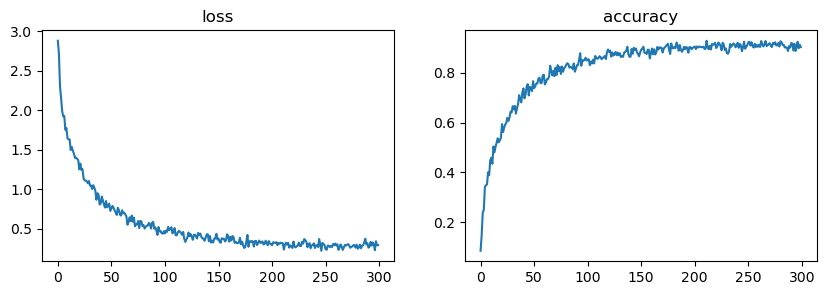

In [30]:
plot_lines(loss_lstm, accucay_lstm)

### Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor, net):
    if net.isLSTM == True:
        h0, c0 = net.initHidden()
    else:
        h0 = net.initHidden()

    if net.isLSTM == True:
        output, h, c = net(line_tensor, h0, c0)
        return output[-1]
    else:
        for i in range(line_tensor.size()[0]):
            output, h0 = net(line_tensor[i], h0)
        return output

def plot_confusion_matrix(net):
    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = evaluate(line_tensor, net)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

d:\Anaconda3\envs\dl_torch\lib\site-packages\ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\Anaconda3\envs\dl_torch\lib\site-packages\ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


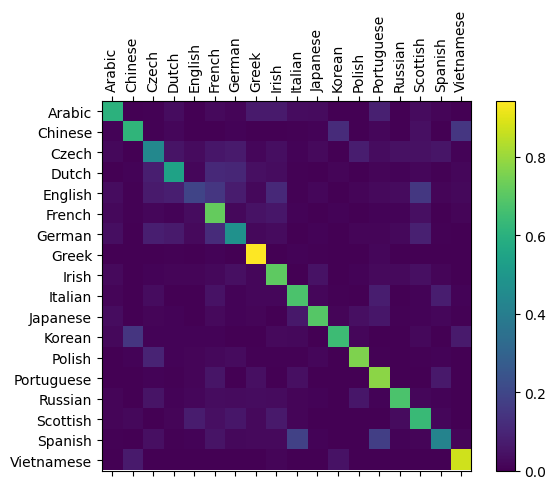

In [21]:
plot_confusion_matrix(rnn)

d:\Anaconda3\envs\dl_torch\lib\site-packages\ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\Anaconda3\envs\dl_torch\lib\site-packages\ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


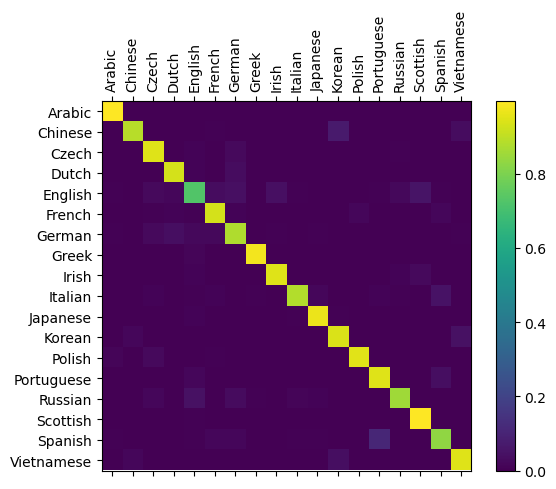

In [31]:
plot_confusion_matrix(lstm)

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

### Running on User Input

In [23]:
import math
import numpy as np

def predict(input_line, net, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), net)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [24]:
predict('Dovesky', rnn)
predict('Dovesky', lstm)
predict('Lin', rnn)
predict('Lin', lstm)


> Dovesky
(0.57) Czech
(0.33) Russian
(0.03) Polish

> Dovesky
(0.70) Russian
(0.29) Czech
(0.01) English

> Lin
(0.64) Chinese
(0.08) Russian
(0.07) Vietnamese

> Lin
(0.80) Chinese
(0.15) Korean
(0.03) Vietnamese


## my LSTM model

In [14]:
from lstm import LSTMModel
n_hidden = 128
my_lstm = LSTMModel(n_letters, n_hidden, n_categories)
print(my_lstm)
input = lineToTensor('Albert')  # (6, 1, 57)
print(input.shape)
h, c = my_lstm.init_hidden()
output, h, c = my_lstm(input[0], h, c)
print(torch.exp(output))

LSTMModel(
  (lstm1): LSTMBlock()
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=18, bias=True)
    (1): LogSoftmax(dim=1)
  )
)
torch.Size([6, 1, 57])
tensor([[0.0520, 0.0525, 0.0555, 0.0512, 0.0562, 0.0559, 0.0606, 0.0551, 0.0604,
         0.0520, 0.0508, 0.0593, 0.0548, 0.0591, 0.0566, 0.0590, 0.0532, 0.0558]],
       grad_fn=<ExpBackward0>)


In [15]:
import torch.optim as optim
criterion = nn.NLLLoss()
learning_rate = 0.1 # If you set this too high, it might explode. If too low, it might not learn

optimizer = optim.SGD(my_lstm.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden1, hidden2 = my_lstm.init_hidden()
    my_lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden1, hidden2 = my_lstm(line_tensor[i], hidden1,hidden2)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

In [16]:
import time
import math

n_iters = 300000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
current_accuracy = 0
all_losses = []
all_accuracy = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    # 添加准确率accuracy
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        current_accuracy +=1

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        all_accuracy.append(current_accuracy/plot_every)
        current_loss = 0
        current_accuracy = 0

5000 1% (0m 24s) 2.0737 Pian / Irish ✗ (Chinese)
10000 3% (0m 47s) 2.1378 Bahr / Arabic ✗ (German)
15000 5% (1m 8s) 0.0786 Acardi / Italian ✓
20000 6% (1m 31s) 0.3269 Donndubhan / Irish ✓
25000 8% (1m 56s) 3.5624 Tunison / Scottish ✗ (Dutch)
30000 10% (2m 20s) 0.8003 Travere / French ✓
35000 11% (2m 44s) 3.8243 Homuha / Japanese ✗ (Russian)
40000 13% (3m 13s) 0.2771 Felix / French ✓
45000 15% (3m 36s) 5.2787 Murray / Scottish ✗ (English)
50000 16% (3m 58s) 5.2512 Chan / Vietnamese ✗ (English)
55000 18% (4m 20s) 0.2270 Ohmae / Japanese ✓
60000 20% (4m 43s) 1.7322 Szwarc / German ✗ (Polish)
65000 21% (5m 5s) 0.4381 Hrula / Czech ✓
70000 23% (5m 27s) 0.3180 Olguin / Spanish ✓
75000 25% (5m 49s) 0.0002 Yamakazi / Japanese ✓
80000 26% (6m 11s) 0.0081 Vipond / French ✓
85000 28% (6m 35s) 0.0368 Peij / Dutch ✓
90000 30% (7m 0s) 0.0098 Faure / French ✓
95000 31% (7m 21s) 0.0609 Black / Scottish ✓
100000 33% (7m 42s) 0.0631 Murray / Scottish ✓
105000 35% (8m 3s) 0.9349 Pattison / French ✗ (Engl

([<matplotlib.axis.YTick at 0x182ea1aea88>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

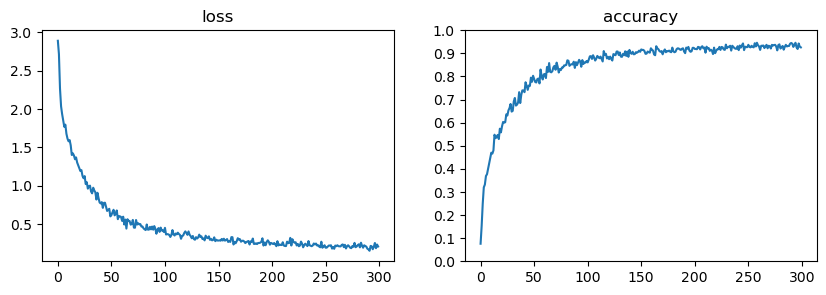

In [19]:
import numpy as np
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(all_losses)
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(all_accuracy)
plt.title("accuracy")
plt.yticks(np.arange(0, 1.1, step=0.1))  # 设置纵坐标的范围为0到1，步长为0.1

d:\Anaconda3\envs\dl_torch\lib\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\Anaconda3\envs\dl_torch\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


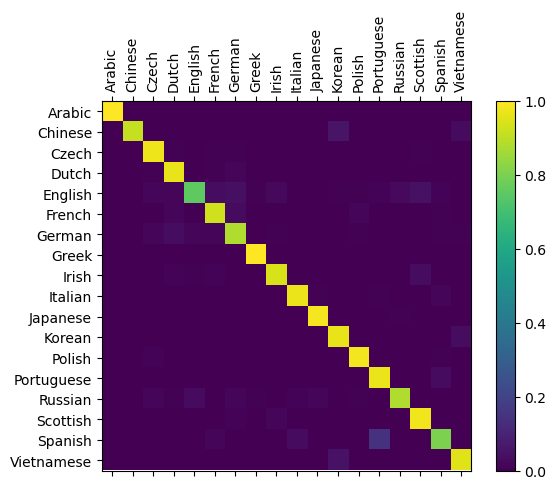

In [21]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden1, hidden2 = my_lstm.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden1, hidden2 = my_lstm(line_tensor[i], hidden1,hidden2)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()